# *Task 1*

*The following Task contains 5 cells with following actions*

1. Loading of delhi_ncr_region.geojson file
2. Making a 60x60 grid over it
3. preprocessing image for bad files i.e. any rgb file without ".png"
4. Filtering of images which falls under *delhi_ncr_region.geojson* region
5. Reporting Total grids, grids with atleast one image, **total image** and **image after processing**



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rishabhsnip/earth-observation-delhi-airshed")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/datasets/rishabhsnip/earth-observation-delhi-airshed


In [2]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box, Point
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

In [3]:
ncr = gpd.read_file("/kaggle/input/datasets/rishabhsnip/earth-observation-delhi-airshed/delhi_ncr_region.geojson")
ncr_m = ncr.to_crs(epsg=32644)
x_m,y_m,x_mx,y_mx = ncr_m.total_bounds
grid = [box(x0, y0, x0 + 60_000, y0 + 60_000)
       for x0 in np.arange(x_m,x_mx,60_000)
       for y0 in np.arange(y_m,y_mx,60_000)]
grid_gdf = gpd.GeoDataFrame({'geometry': grid}, crs=ncr_m.crs)


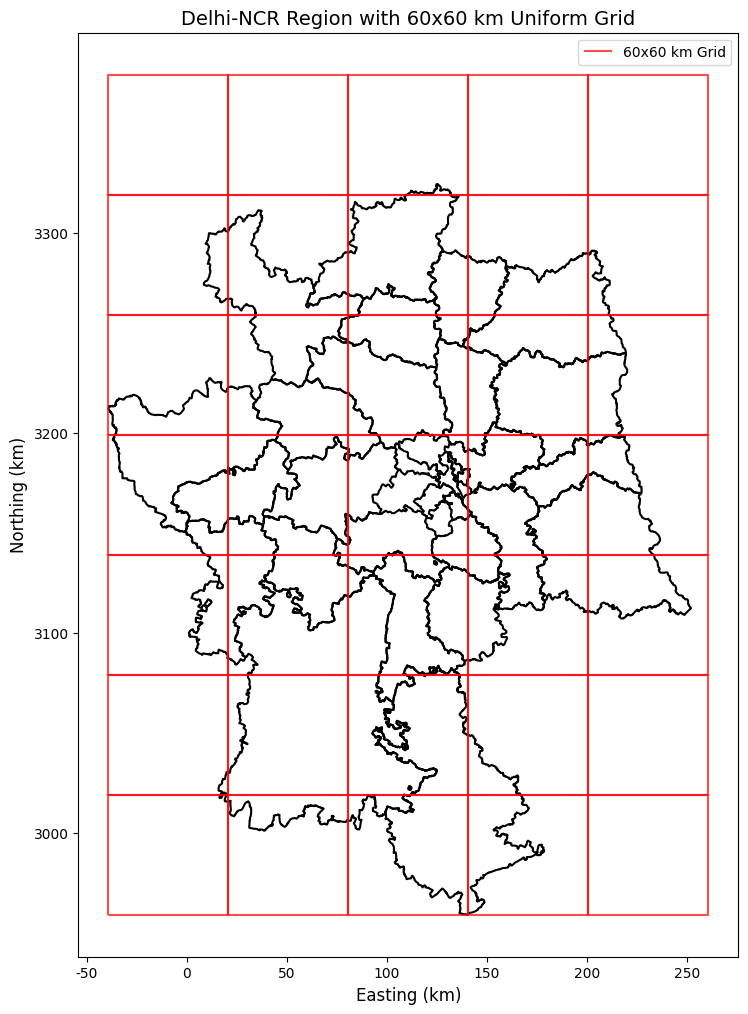

In [4]:
def _m_to_km(x, _):
    return f'{x/1000:.0f}'

fig, ax = plt.subplots(figsize=(12, 12))
ncr_m.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)
grid_gdf.boundary.plot(ax=ax, color='red', linewidth=1.5, alpha=0.7, label='60x60 km Grid')
ax.xaxis.set_major_formatter(FuncFormatter(_m_to_km))
ax.yaxis.set_major_formatter(FuncFormatter(_m_to_km))
ax.set_xlabel('Easting (km)', fontsize=12)
ax.set_ylabel('Northing (km)', fontsize=12)
ax.set_title('Delhi-NCR Region with 60x60 km Uniform Grid', fontsize=14)
ax.set_aspect('equal')
plt.legend()
plt.show()

In [5]:
image_dir = "/kaggle/input/datasets/rishabhsnip/earth-observation-delhi-airshed/rgb"

coord = []
valid_img = []
for image in os.listdir(image_dir):
    if not image.endswith(".png"):
        continue #skips all non.png files
    try:
        Ycod,Xcod = map(float,image.replace('.png','').split("_"))
        coord.append(Point(Xcod,Ycod))
        valid_img.append(image)
    except:
        continue

print("Total Images after initial cleaning",len(valid_img)) 

Total Images after initial cleaning 9216


In [6]:
image_gdf = gpd.GeoDataFrame({'filename': valid_img},geometry = coord, crs="EPSG:4326")
image_meters = image_gdf.to_crs(epsg=32644)
filter_img = gpd.sjoin(image_meters,ncr_m,predicate = 'within').drop(columns=['index_right'])
non_empty_grids = gpd.sjoin(grid_gdf, filter_img, predicate='intersects').index.nunique()

print("Total Images before filtering: ",len(valid_img))
print("Total Images after filtering: ", len(filter_img))
print("Total Grid: ",len(grid_gdf))
print("Total Grid with images: ", non_empty_grids)

Total Images before filtering:  9216
Total Images after filtering:  8015
Total Grid:  35
Total Grid with images:  6


# **Task 2**

*The following task contains 2 cells which performs the following actions*

1. Import the necessary libaries
2. Maps every Images to ESA Label based on the most dominent group present in the image
3. Splits the data into traning and testing data frame and visualizes it

In [7]:
import rasterio
from rasterio.mask import mask
from scipy import stats
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns

Processing Patches: 100%|██████████| 8015/8015 [00:18<00:00, 433.32it/s]


Splitting the Data....


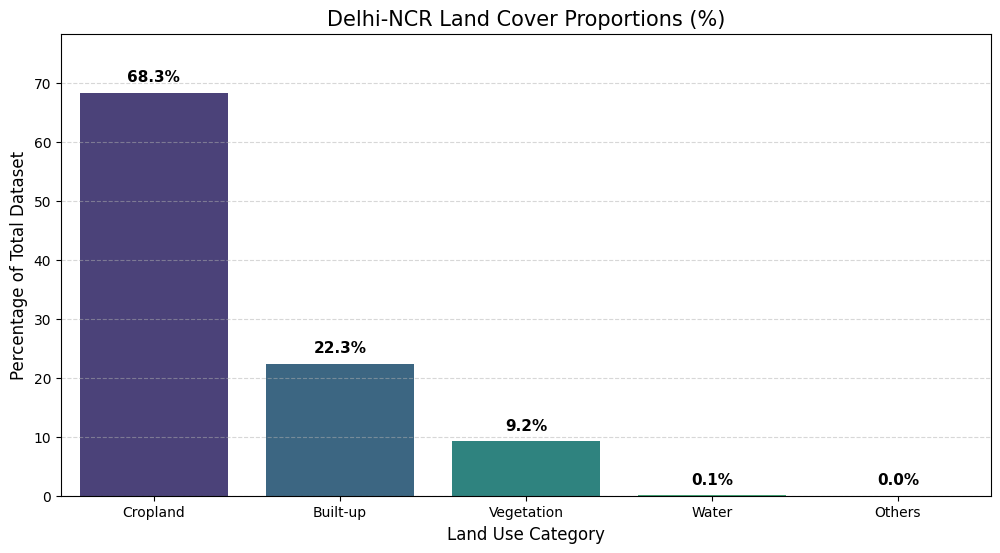

=====Final Stats for Training Data=====
Total Images:  8015
Training Data(60%):  4809
Test Data(40%):  3206
=====Total images in % in Test data=====
label
Cropland      68.3%
Built-up      22.4%
Vegetation     9.2%
Water          0.1%
Others         0.0%
Name: proportion, dtype: object


In [8]:
ESA_LABEL_MAP = {
    10: 'Vegetation', 20: 'Vegetation', 30: 'Vegetation',
    40: 'Cropland',
    50: 'Built-up',
    80: 'Water',
    60: 'Others', 70: 'Others', 90: 'Others', 95: 'Others', 100: 'Others'
}

map_obj = rasterio.open('/kaggle/input/datasets/rishabhsnip/earth-observation-delhi-airshed/worldcover_bbox_delhi_ncr_2021.tif')
image_aligned = filter_img.to_crs(map_obj.crs)
results = []
for img_id, data in tqdm(image_aligned.iterrows(),colour='blue', total=len(image_aligned), desc="Processing Patches"):
    try:
        x_axis,y_axis = data.geometry.x, data.geometry.y
        half = (128*0.00009)/2
        boxx = box(x_axis-half,y_axis-half,x_axis+half,y_axis+half)
        patch,_ = mask(map_obj,[boxx],crop=True)
        if patch.size > 0:
            dominant = int(stats.mode(patch[0].flatten(),keepdims = True).mode[0])
            results.append({'filename': data['filename'], 'label': ESA_LABEL_MAP.get(dominant,'Others')})
    except:
        pass

table_o_final_data = pd.DataFrame(results)

#Spliting the data
print("Splitting the Data....")
train_df,test_df = train_test_split(table_o_final_data, test_size = 0.40, random_state=42, stratify = table_o_final_data['label'])

#Visualise The Classess
percentages = (table_o_final_data['label'].value_counts() / len(table_o_final_data)) * 100

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=percentages.index, y=percentages.values,
            hue=percentages.index, palette='viridis', legend=False, ax=ax)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', xytext=(0, 6),
                textcoords='offset points', fontsize=11, fontweight='bold')
ax.set_title('Delhi-NCR Land Cover Proportions (%)', fontsize=15)
ax.set_xlabel('Land Use Category', fontsize=12)
ax.set_ylabel('Percentage of Total Dataset', fontsize=12)
ax.set_ylim(0, percentages.max() + 10)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("="*5+"Final Stats for Training Data"+"="*5)
print("Total Images: ",len(table_o_final_data))
print("Training Data(60%): ",len(train_df))
print("Test Data(40%): ",len(test_df))
print("=====Total images in % in Test data=====")
print((test_df["label"].value_counts(normalize=True) * 100).round(1).map("{}%".format)) #Proves our Normalization worked
        

# Task 3 

*Following Cell does the following tasks*

1. Drops the rare classes as its impossible to have any meaniningful traning out of it 
2. Splits Test dataframe into 80/20 ratio for Training and Validation
3. Sets up Heavy Augmentation and Deterministic Augmentation to Training and Testing phase
4. Uses "Effective Number" Math (Cui et al., 2019) for weights
5. Sets up Focal Loss with Gamma = 1.5
6. Uses Test Time Augmentation
7. Displays Accuracy,Macro F1 socre and Classification Records
8. Displays normalized Confusion Matrix 

In [9]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from torchvision import transforms
import torch

In [10]:
#Global Var
IMG_PATH = "/kaggle/input/datasets/rishabhsnip/earth-observation-delhi-airshed/rgb"


Rare = ['Water','Others']
training_o_data = table_o_final_data[~table_o_final_data['label'].isin(Rare)].copy()

#Need for resplitting for training
train_df,test_df = train_test_split(training_o_data,test_size = 0.40, random_state = 42,stratify=training_o_data['label'])
# Creation of class
all_class = sorted(training_o_data['label'].unique())
class_2_index = {lbl: indx for indx,lbl in enumerate(all_class)} # For AI
index_2_class = {indx : lbl for lbl,indx in class_2_index.items()} # For Humans

print("Number of Classes: ",len(index_2_class))

class Waiter(Dataset):
    def __init__(self,df,img_path,class_2_index,transform=None):
        self.df = df.reset_index(drop=True)
        self.img_path = img_path
        self.class_2_index = class_2_index
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self,indx):
        row = self.df.iloc[indx]
        image = Image.open(os.path.join(self.img_path,row['filename'])).convert('RGB')
        label = self.class_2_index[row['label']]
        if self.transform:
            image = self.transform(image)
        return image,label


# Training Augemntation 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Testing/Validating Augmentation
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split into 80/20 Train, Validation dataframe
final_o_train,valido = train_test_split(train_df, test_size = 0.20,stratify=train_df['label'], random_state=42)

class_counts = final_o_train['label'].value_counts()
counts_arr = np.array([class_counts.get(l, 1) for l in all_class], dtype=np.float32)

# 2. The "Effective Number" Math (Cui et al., 2019)
beta = 0.9999
eff_num = 1.0 - np.power(beta, counts_arr)
cb_weights = (1.0 - beta) / eff_num
cb_weights = cb_weights / cb_weights.sum() * len(all_class)
cb_weight_tensor = torch.tensor(cb_weights, dtype=torch.float)
print(f"Calculated Weights: {cb_weights}")

train_loader = DataLoader(
    Waiter(final_o_train, IMG_PATH, class_2_index, train_transform), 
    batch_size=32,   # 32 images at a time
    shuffle=True,    
    num_workers=2,   
    pin_memory=True  
)

val_loader = DataLoader(
    Waiter(valido, IMG_PATH, class_2_index, eval_transform),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    Waiter(test_df, IMG_PATH, class_2_index, eval_transform), 
    batch_size=32, 
    shuffle=False
)


Number of Classes:  3
Calculated Weights: [0.8058913  0.28685403 1.9072548 ]


In [11]:
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from sklearn.metrics import (accuracy_score, f1_score,confusion_matrix, classification_report)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [12]:
class FocalLoss(nn.Module):
    def __init__(self,alpha,gamma =1.5,smooth_weights=0.1):
        super().__init__()
        self.register_buffer('alpha',alpha)
        self.gamma = gamma
        self.smooth_weight = smooth_weights
        self.ce_hard = nn.CrossEntropyLoss(reduction='none')
        self.ce_smooth = nn.CrossEntropyLoss(reduction='none', label_smoothing=0.1)
        
    def forward(self, inputs, targets):
        pt = torch.softmax(inputs, dim=1).gather(1, targets.unsqueeze(1)).squeeze(1)
        at = self.alpha[targets]
        focal_w = at * (1.0 - pt) ** self.gamma
        loss = focal_w * self.ce_hard(inputs, targets) + self.smooth_weight * self.ce_smooth(inputs, targets)
        return loss.mean()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device,"Is being used Currently")

model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
NUM_CLASSES = len(all_class)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES) # Da Transfer learning
model = model.to(device)

criterion = FocalLoss(alpha=cb_weight_tensor.to(device),gamma=1.5)
optimizer = optim.AdamW(model.parameters(),lr = 1e-4,weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',factor=0.1,patience=2)


#Training Loop
Runs = 30
Early_stopping = 5
best_val_f1 = 0
Runs_No_Improve = 0

for Run in range(Runs):
    model.train()
    total_train_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f'Epoch {Run+1}/{Runs}', colour='blue')
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    model.eval()
    pred, truth = [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs, 1)
            pred.extend(predicted.cpu().numpy())
            truth.extend(labels.numpy())
    
    val_macro = f1_score(truth, pred, average='macro', zero_division=0)
    scheduler.step(val_macro)

    print("Epoch: ", Run + 1)
    print("Loss: ", round(total_train_loss / len(train_loader), 4))
    print("Macro F1: ", round(val_macro, 4))
    
    current_lr = optimizer.param_groups[0]['lr']
    print("Current LR: ", current_lr)

    if val_macro > best_val_f1:
        best_val_f1 = val_macro
        torch.save(model.state_dict(), 'best_model.pth')
        Runs_No_Improve = 0
    else:
        Runs_No_Improve += 1
        
    if Runs_No_Improve >= Early_stopping:
        print("Stopping early")
        break



cuda Is being used Currently
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 178MB/s]
Epoch 1/30: 100%|██████████| 121/121 [00:40<00:00,  3.02it/s, loss=0.316] 


Epoch:  1
Loss:  0.2117
Macro F1:  0.8238
Current LR:  0.0001


Epoch 2/30: 100%|██████████| 121/121 [00:29<00:00,  4.11it/s, loss=0.035] 


Epoch:  2
Loss:  0.1442
Macro F1:  0.8535
Current LR:  0.0001


Epoch 3/30: 100%|██████████| 121/121 [00:30<00:00,  3.98it/s, loss=0.513] 


Epoch:  3
Loss:  0.1301
Macro F1:  0.857
Current LR:  0.0001


Epoch 4/30: 100%|██████████| 121/121 [00:29<00:00,  4.08it/s, loss=0.238] 


Epoch:  4
Loss:  0.1096
Macro F1:  0.866
Current LR:  0.0001


Epoch 5/30: 100%|██████████| 121/121 [00:29<00:00,  4.05it/s, loss=0.544] 


Epoch:  5
Loss:  0.1024
Macro F1:  0.886
Current LR:  0.0001


Epoch 6/30: 100%|██████████| 121/121 [00:29<00:00,  4.05it/s, loss=0.0474]


Epoch:  6
Loss:  0.1029
Macro F1:  0.8834
Current LR:  0.0001


Epoch 7/30: 100%|██████████| 121/121 [00:29<00:00,  4.05it/s, loss=0.288] 


Epoch:  7
Loss:  0.0929
Macro F1:  0.8447
Current LR:  0.0001


Epoch 8/30: 100%|██████████| 121/121 [00:29<00:00,  4.06it/s, loss=0.0763]


Epoch:  8
Loss:  0.0943
Macro F1:  0.8671
Current LR:  1e-05


Epoch 9/30: 100%|██████████| 121/121 [00:29<00:00,  4.06it/s, loss=0.0657]


Epoch:  9
Loss:  0.0718
Macro F1:  0.8612
Current LR:  1e-05


Epoch 10/30: 100%|██████████| 121/121 [00:29<00:00,  4.05it/s, loss=0.0855]


Epoch:  10
Loss:  0.0716
Macro F1:  0.8837
Current LR:  1e-05
Stopping early


Final Evaluation (TTA): 100%|██████████| 101/101 [01:02<00:00,  1.61it/s]


==================================================Reports!==================================================
Accuracy       :  0.9285
Macro F1-Score :  0.8759
              precision    recall  f1-score   support

    Built-up       0.87      0.95      0.91       717
    Cropland       0.99      0.94      0.96      2191
  Vegetation       0.71      0.81      0.76       295

    accuracy                           0.93      3203
   macro avg       0.86      0.90      0.88      3203
weighted avg       0.93      0.93      0.93      3203



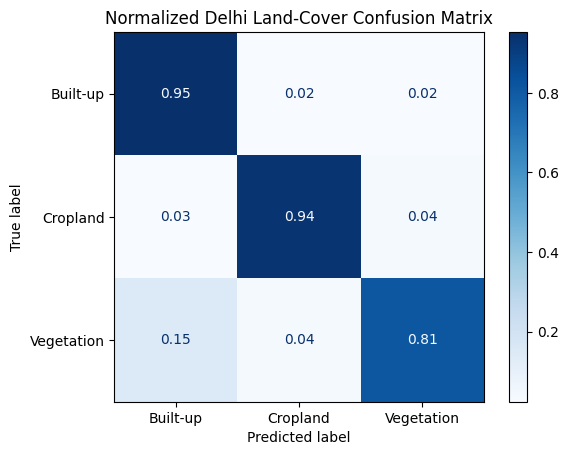

In [13]:
#Model evaluation 
model.load_state_dict(torch.load('best_model.pth',map_location=device))
model.eval()

#Test Time Augemrntation 5 test per image

TTA_Aug = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomRotation((90,  90)),
    transforms.RandomRotation((180, 180)),
]

def predict_tta(model,images):
    prob = torch.softmax(model(images), dim=1)
    for transformation in TTA_Aug:
        transformed_batch = transformation(images)
        prob = prob + torch.softmax(model(transformed_batch), dim=1)
    return prob / (len(TTA_Aug) + 1)

pred, actual = [],[]
pbar = tqdm(test_loader, desc="Final Evaluation (TTA)", colour='blue')
with torch.no_grad():
    for images, labels in pbar:
        prob = predict_tta(model,images.to(device))
        pred.extend(prob.argmax(1).cpu().numpy())
        actual.extend(labels.numpy())

# Number and Visualization

unique_classes = np.unique(np.concatenate([actual,pred]))
Name_o_Classes = [index_2_class[x] for x in unique_classes]
print("="*50+'Reports!'+"="*50)
print("Accuracy       : ", round(accuracy_score(actual, pred), 4))
print("Macro F1-Score : ", round(f1_score(actual, pred, average="macro", zero_division=0), 4))
print("="*108)

# Detalied classwise classification 
print(classification_report(actual, pred,labels=unique_classes,target_names=Name_o_Classes,zero_division=0))

# Making a confusion Matrix
cm_normalized = confusion_matrix(actual, pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=all_class)
disp.plot(cmap='Blues', values_format='.2f')
plt.title("Normalized Delhi Land-Cover Confusion Matrix")
plt.show()

        

In [14]:
from IPython.display import FileLink
FileLink('best_model.pth')

/kaggle/working/best_model.pth